In [1]:
from torch.utils.data import Dataset,DataLoader
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
from functools import partial
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import optim
from mmseg.models.uda.swinir_backbone import MGDNRefinement
from mmseg.models.uda.refinement import EncodeDecode
from tqdm import tqdm
import numpy as np
from refinement_module import UNet
from torch.optim.lr_scheduler import OneCycleLR
import random
from models import Refine
from Datasets import WeihToI3

/home/sow/venv/prism-uda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = WeihToI3(mode="val")

In [3]:
a = ds[1][0].float().unsqueeze(0)

In [4]:
a.shape

torch.Size([1, 1, 256, 256])

In [5]:
ds[1][1].shape

torch.Size([1, 256, 256])

In [6]:
model = MGDNRefinement()

In [7]:
model(a,a).shape

torch.Size([1, 19, 256, 256])

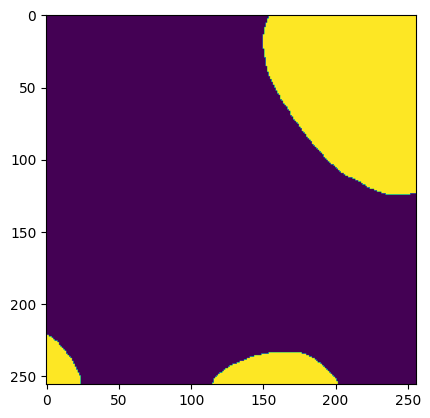

In [8]:
plt.imshow(a.squeeze())

In [9]:
def compute_iou(preds:torch.Tensor,gt:torch.Tensor,num_classes=2,ignore_index=255):
    mask = gt != ignore_index
    preds = preds[mask]
    gt = gt[mask]

    iou_list = []

    for cls in range(num_classes):
        cls_in_preds = preds == cls
        cls_in_gt = gt == cls

        intersection = (cls_in_preds & cls_in_gt).sum().item()
        union = (cls_in_preds | cls_in_gt).sum().item()

        if union == 0:
            iou_list.append(0)
            continue  # this class is not present in gt

        iou = intersection / union
        iou_list.append(iou)

    if not iou_list:
        raise ValueError("No class found in this predictions")
    return sum(iou_list) / len(iou_list)

def plot(pl:torch.Tensor,
         sam:torch.Tensor,
         preds:torch.Tensor,
         gt:torch.Tensor,
         epoch,
         batch_id,
         model_name,
         dataset_type,mask_type
         ):
    if batch_id % 200==0:
        pl = pl.squeeze().detach().cpu().numpy()
        sam = sam.squeeze().detach().cpu().numpy()
        preds = preds.squeeze().detach().cpu().numpy()
        gt = gt.squeeze().detach().cpu().numpy()

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

        axes[0].imshow(pl)
        axes[0].set_title("Pseudo label de l'EMA")

        axes[1].imshow(sam)
        axes[1].set_title("SAM")

        axes[2].imshow(preds)
        axes[2].set_title("Prédictions du raffineur")

        axes[3].imshow(gt)
        axes[3].set_title("Ground truth")

        plt.tight_layout()

        os.makedirs(f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/debug", exist_ok=True)
        plt.savefig(f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/debug/{epoch}_{batch_id}.png")
        plt.close(fig)

def save_metrics(train_losses,val_losses,train_m_iou,val_m_iou,model_name,dataset_type,mask_type):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_m_iou, label="Train mIoU")
    plt.plot(val_m_iou, label="Val mIoU")
    plt.legend()
    plt.title("Mean IoU")
    plt.savefig(f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/metrics.png")
    plt.close()


def one_batch(model,model_name,epoch,device,
              batch,batch_id,
              optimizer:optim.Optimizer,
              loss_function:nn.CrossEntropyLoss,
              dataset_type:str,mask_type,
              on_training=True):
    model.train() if on_training else model.eval()
    if dataset_type == "i3":
        pl,sam,gt = batch
        pl,sam,gt = pl.float(),sam.float(),gt.long()
        pl,sam,gt = pl.to(device),sam.to(device),gt.to(device)
        preds = model(pl,sam)
    else :
        sam,gt = batch
        sam,gt = sam.float(),gt.long()
        sam,gt = sam.to(device),gt.to(device)
        preds = model(sam,sam) 
    loss = loss_function(preds,gt.squeeze(1))
    if on_training:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    preds = preds.argmax(dim=1)

    iou = compute_iou(preds,gt.squeeze(1))

    if not on_training :
        if dataset_type == "i3":
            plot(pl,sam,preds,gt,epoch,batch_id,model_name,dataset_type,mask_type)
        else :
            plot(sam,sam,preds,gt,epoch,batch_id,model_name,dataset_type,mask_type)

    return loss.item(), iou


def one_epoch(model,model_name,epoch,device,
              dataloader: DataLoader,
              optimizer:optim.Optimizer,
              loss_function:nn.CrossEntropyLoss,
              dataset_type:str,mask_type,
              on_training=True):
    train_loss = 0
    m_iou = 0
    N = 0
    for batch_id,batch in enumerate(dataloader):
        loss,iou = one_batch(model=model,model_name=model_name,mask_type=mask_type,epoch=epoch,device=device,batch=batch,batch_id=batch_id,optimizer=optimizer,dataset_type=dataset_type, loss_function=loss_function,on_training=on_training)
        if batch_id % 100 == 0: 
            print("train_loss = ",loss," epoch = ",epoch," batch_id = ",batch_id)
        train_loss = train_loss + loss
        m_iou = m_iou + iou
        N += 1
    return train_loss / N, m_iou / N

def train(model,max_epochs,lr,train_dl,val_dl,model_name,dataset_type,mask_type):
    train_losses = []
    val_losses = []
    train_m_iou = []
    val_m_iou = []
    device = "cuda" #if torch.cuda.is_available() else "cpu"
    best_val_iou = 1000

    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(),lr=lr)
    weight = torch.tensor([1.,5.],device=device)  
    loss_function = nn.CrossEntropyLoss(ignore_index=255)
    progress_bar = tqdm(range(max_epochs))

    if dataset_type == "i3":
        train_dataset = "i3"
        val_dataset = "i3"
    else:
        train_dataset = "weih"
        val_dataset = "weih"
    for epoch in progress_bar:
        train_loss, train_iou = one_epoch(model=model,model_name=model_name,mask_type=mask_type,epoch=epoch,device=device,dataloader=train_dl,optimizer=optimizer,dataset_type=train_dataset,loss_function=loss_function,on_training=True)
        train_losses.append(train_loss)
        train_m_iou.append(train_iou)
        with torch.no_grad():
            val_loss, val_iou = one_epoch(model=model,model_name=model_name,mask_type=mask_type,epoch=epoch,device=device,dataloader=val_dl,optimizer=optimizer,dataset_type=val_dataset,loss_function=loss_function,on_training=False)
            val_losses.append(val_loss)
            val_m_iou.append(val_iou)
        progress_bar.set_postfix(dict(train_loss=train_loss,train_iou=train_iou,val_loss=val_loss,val_iou=val_iou))
        # save losses and IoU
        save_metrics(train_losses,val_losses,train_m_iou,val_m_iou,model_name,dataset_type,mask_type=mask_type)
        if val_iou < best_val_iou:
            best_val_iou = val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': val_iou
            }, f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/best_checkpoint.pth")

In [2]:
train_ds = WeihToI3(mode="train",)
val_ds = WeihToI3(mode="val",)
train_dl = DataLoader(train_ds,2,True,num_workers=8)
val_dl = DataLoader(val_ds,1,False,num_workers=8)

In [10]:
train_ds[1][0].unique()

tensor([0, 1], dtype=torch.uint8)

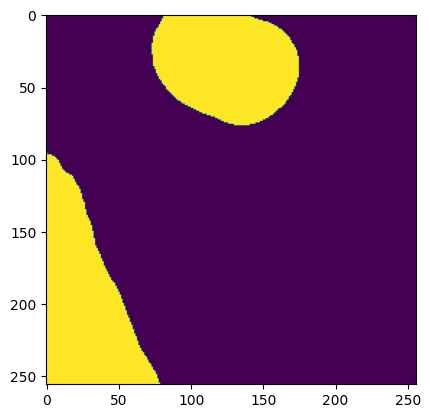

In [11]:
plt.imshow(train_ds[0][0].squeeze())

In [12]:
len(train_dl),len(val_dl)

(4182, 3585)

In [13]:
torch.cuda.empty_cache()

In [14]:
model = EncodeDecode("cpu")

In [15]:
train(model,50,1e-4,train_dl,val_dl,"Refine","i3","colour")

  0%|          | 0/50 [00:00<?, ?it/s]

train_loss =  0.6945216059684753  epoch =  0  batch_id =  0
train_loss =  0.06476244330406189  epoch =  0  batch_id =  100
train_loss =  0.11600480228662491  epoch =  0  batch_id =  200
train_loss =  0.11343853175640106  epoch =  0  batch_id =  300
train_loss =  0.10284766554832458  epoch =  0  batch_id =  400
train_loss =  0.08840977400541306  epoch =  0  batch_id =  500
train_loss =  0.11501836776733398  epoch =  0  batch_id =  600
train_loss =  0.2542673349380493  epoch =  0  batch_id =  700
train_loss =  0.023665552958846092  epoch =  0  batch_id =  800
train_loss =  0.034662265330553055  epoch =  0  batch_id =  900
train_loss =  0.015140673145651817  epoch =  0  batch_id =  1000
train_loss =  0.07298003882169724  epoch =  0  batch_id =  1100
train_loss =  0.031191840767860413  epoch =  0  batch_id =  1200
train_loss =  0.017476603388786316  epoch =  0  batch_id =  1300
train_loss =  0.09785325080156326  epoch =  0  batch_id =  1400
train_loss =  0.027158332988619804  epoch =  0  b

  2%|▏         | 1/50 [25:11<20:34:45, 1511.95s/it, train_loss=0.0612, train_iou=0.847, val_loss=0.0457, val_iou=0.741]

train_loss =  0.004128612577915192  epoch =  1  batch_id =  0
train_loss =  0.01526473369449377  epoch =  1  batch_id =  100


  2%|▏         | 1/50 [26:01<21:15:03, 1561.30s/it, train_loss=0.0612, train_iou=0.847, val_loss=0.0457, val_iou=0.741]


KeyboardInterrupt: 